In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import pandas as pd
import jieba
dtype = torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
train=pd.read_csv('train.tsv', sep='\t')
sentences=[]
for sen in train['text']:
    sentences.append(jieba.lcut(sen))
print(sentences[0])
train

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86189\AppData\Local\Temp\jieba.cache
Loading model cost 0.776 seconds.
Prefix dict has been built successfully.


['备胎', '是', '硬伤', '！']


,Unnamed: 0,label,text
0,0,0,备胎是硬伤！
1,1,0,要说不满意的话，那就是动力了，1.5自然吸气发动机对这款车有种小马拉大车的感觉。如今天气这么...
2,2,0,油耗显示13升还多一点，希望慢慢下降。没有倒车雷达真可恨
3,3,0,空调不太凉，应该是小问题。
4,4,0,1、后排座椅不能平放；2、科技感不强，还不如百万帝豪，最希望增加车联网的车机。像你好博越一样...
...,...,...,...
56695,56695,1,刹车！给人无比信心的刹车！高峰时段可以跑到100的，没有人会拘泥于80，这就是中环。这也是迅...
56696,56696,1,操控性好，性价比高，油耗低
56697,56697,0,空间有点小了本来想买凯翼7座的v3不给力要等两三个月才到车。
56698,56698,0,最不满意的地方就是没有自动挡的，为什么差速锁不是四驱标配啊，当时提车比较着急，现车没有差速锁...


In [7]:
test=pd.read_csv('test.tsv', sep='\t')
test_sentences=[]
for sen in test['text']:
    test_sentences.append(jieba.lcut(sen))
# print(sentences[0])
test_labels=list(test['label'])
labels=list(train['label'])
test

,Unnamed: 0,label,text
0,0,1,操控性舒服、油耗低，性价比高
1,1,0,动力的确有点点让我相信了up的确是个代步车而已!
2,2,1,1。车的外观很喜欢。2。省油，现在磨合期7.3，相信以后还会下降。
3,3,1,内饰的做工和用料同级别同价位最厚道的
4,4,0,减震系统太硬！
...,...,...,...
6295,6295,1,兄弟们玩车震蛮到位嘀！
6296,6296,1,空间大，减震性也非常好，而且那个波箱啊，换来这样的方便。
6297,6297,1,配置丰富
6298,6298,0,噪音太大，内饰做工非常粗糙。


In [8]:
# TextCNN Parameter
sequence_length=0
for i in sentences:
    sequence_length=max(len(i),sequence_length)
embedding_size = 6  
num_classes = len(set(labels))  # num_classes=2
batch_size = 3
print(sequence_length)

91


In [9]:
word2dic={}
num=1
for i in sentences:
    for j in i:
        if j not in word2dic:
            word2dic[j]=num
            num=num+1
vocab_size = len(word2dic)+1

In [12]:
def make_data(sentences, labels):
  inputs = []
  for sen in sentences:
        temp=[0 for i in range(sequence_length)]
        for word in range(len(sen)):
            if sen[word] in word2dic:
                temp[word]=word2dic[sen[word]]
        inputs.append(temp)
  targets = []
  for out in labels:
      targets.append(out) # To using Torch Softmax Loss function
  return inputs, targets

input_batch, target_batch = make_data(sentences, labels)
input_batch, target_batch = torch.LongTensor(input_batch), torch.LongTensor(target_batch)
dataset = Data.TensorDataset(input_batch, target_batch)
loader = Data.DataLoader(dataset, batch_size, True)

In [26]:
test_batch,test_target=make_data(test_sentences, test_labels)
test_batch,test_target= torch.LongTensor(test_batch), torch.LongTensor(test_target)

In [19]:
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.W = nn.Embedding(vocab_size, embedding_size)
        output_channel = 3
        self.conv = nn.Sequential(
            nn.Conv2d(1, output_channel, (2, embedding_size)),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
        )
        self.fc = nn.Linear(output_channel*45, num_classes)

    def forward(self, X):
      '''
      X: [batch_size, sequence_length]
      '''
      batch_size = X.shape[0]
      embedding_X = self.W(X) # [batch_size, sequence_length, embedding_size]
      embedding_X = embedding_X.unsqueeze(1) # add channel(=1) [batch, channel(=1), sequence_length, embedding_size]
      conved = self.conv(embedding_X) # [batch_size, output_channel*1*1]
      flatten = conved.view(batch_size, -1)
      output = self.fc(flatten)
      return output

In [50]:
model = TextCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
for epoch in range(5):
  for batch_x, batch_y in loader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    pred = model(batch_x)
    loss = criterion(pred, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # # Predict
  model = model.eval()
  predict = model(test_batch).data.max(1, keepdim=True)[1]
  pred=[]
  for i in list(predict):
    for j in i:
        pred.append(int(j))
  real=[int(i) for i in test_target]
  tp=0
  tn=0
  fp=0
  fn=0
  for i,j in zip(pred,real):
    if i==1 and j==1:
        tp=tp+1
    if i==0 and j==0:
        tn=tn+1
    if i==1 and j==0:
        fp=fp+1
    if i==0 and j==1:
        fn=fn+1
  print('Epoch:','%04d' % (epoch + 1), 'loss =','{:.6f}'.format(loss))
  print('查准率:',tp/(tp+fp))
  print('查全率:',tp/(tp+fn))

Epoch: 0001 loss = 0.011204
查准率: 0.9233947870311506
查全率: 0.920468948035488
Epoch: 0002 loss = 0.126003
查准率: 0.9394035532994924
查全率: 0.938212927756654
Epoch: 0003 loss = 0.014589
查准率: 0.948791348600509
查全率: 0.9451837769328264
Epoch: 0004 loss = 0.081284
查准率: 0.944251968503937
查全率: 0.949936628643853
Epoch: 0005 loss = 0.002561
查准率: 0.9534735500318674
查全率: 0.9480354879594424


In [69]:
for i in range(6296,6300):
    print('测试数据:',test['text'][i])
    if pred[i]==1:
        print('测试结果:','好评价')
    else:
        print('测试结果:','差评价')
    print('**********')

测试数据: 空间大，减震性也非常好，而且那个波箱啊，换来这样的方便。
测试结果: 好评价
**********
测试数据: 配置丰富
测试结果: 好评价
**********
测试数据: 噪音太大，内饰做工非常粗糙。
测试结果: 差评价
**********
测试数据: 高速的时候风噪还是很大的，胎噪也一样，悬挂反馈还是挺明显的。
测试结果: 差评价
**********


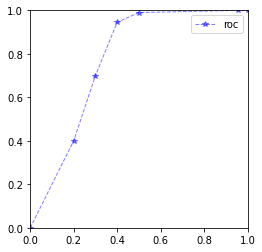

In [67]:
# roc曲线
import matplotlib.pyplot as plt
import numpy as np

y_axis_data = [0,0.4,0.7,0.9451,0.9899,1,1] #x
x_axis_data = [0,0.2,0.3,0.4,0.5,0.9534,1] #y
plt.xlim(0, 1)

plt.ylim(0, 1)
plt.plot(x_axis_data, y_axis_data, 'b*--', alpha=0.5, linewidth=1, label='roc')#'bo-'表示蓝色实线，数据点实心原点标注
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()  #显示上面的label